In [19]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации
 
from sklearn import metrics #метрики
from sklearn import model_selection #методы разделения и валидации
from sklearn import linear_model #линейные модели
from sklearn import tree #деревья решений
from imblearn.over_sampling import SMOTE

In [35]:
water_data = pd.read_csv('data/water_potability.csv')
#Заполняем пропуски
water_data['ph'] = water_data['ph'].fillna(water_data.groupby('Potability')['ph'].transform('median'))
water_data['Sulfate'] = water_data['Sulfate'].fillna(water_data.groupby('Potability')['Sulfate'].transform('median'))
water_data['Trihalomethanes'] = water_data['Trihalomethanes'].fillna(water_data.groupby('Potability')['Trihalomethanes'].transform('median'))

X = water_data.drop('Potability', axis=1)
y = water_data['Potability']

X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


In [21]:
sm = SMOTE(random_state=2)
X_train_s, y_train_s = sm.fit_resample(X_train, y_train)

print('Train shape before oversampling:', X_train.shape) 
print('Class balance before oversampling: \n', y_train.value_counts(), sep='')
print('-'*40)
print('Train shape after oversampling:', X_train_s.shape)
print('Class balance after oversampling: \n', y_train_s.value_counts(), sep='')

Train shape before oversampling: (2620, 9)
Class balance before oversampling: 
Potability
0    1598
1    1022
Name: count, dtype: int64
----------------------------------------
Train shape after oversampling: (3196, 9)
Class balance after oversampling: 
Potability
0    1598
1    1598
Name: count, dtype: int64


In [22]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42, #генератор случайных чисел
)
#Обучаем модель на тренировочной выборке (с сэмплированием)
model.fit(X_train_s, y_train_s)
#Делаем предсказание для каждой из выборок
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
#Выводим значения метрик    
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.83      0.70      0.76       400
           1       0.63      0.78      0.69       256

    accuracy                           0.73       656
   macro avg       0.73      0.74      0.73       656
weighted avg       0.75      0.73      0.73       656



In [23]:
#Создаём модель
model_bad = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    class_weight='balanced', #веса классов
    random_state=42 #генератор случайных чисел
)
#Обучаем модель на тренировочной выборке
model_bad.fit(X_train, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = model_bad.predict(X_train)
y_valid_pred = model_bad.predict(X_valid)
#Выводим значения метрик для тренировочной выборки
print('Train F1 score: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
#Выводим значения метрик для валидационной выборки
print('Valid F1 score: {:.2f}'.format(metrics.f1_score(y_valid, y_valid_pred)))
 
# Train F1 score: 1.00
# Valid F1 score: 0.67

Train F1 score: 1.00
Valid F1 score: 0.67


In [24]:
#Создаём объект кросс-валидатора k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
 
#Считаем метрики на кросс-валидации k-fold со стратификацией
cv_metrics = model_selection.cross_validate(
    estimator=model_bad, #модель
    X=X, #матрица наблюдений X
    y=y, #вектор ответов y
    cv=skf, #кросс-валидатор
    scoring='f1', #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)
display(cv_metrics)

{'fit_time': array([0.04562235, 0.04667592, 0.05171084, 0.04371142, 0.04710317]),
 'score_time': array([0.00399065, 0.00531483, 0.00500917, 0.00399995, 0.00378585]),
 'test_score': array([0.61445783, 0.68421053, 0.62332696, 0.63276836, 0.70119522]),
 'train_score': array([1., 1., 1., 1., 1.])}

In [25]:
print('Train k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['test_score'])))
## Train k-fold mean f1: 1.00
## Valid k-fold mean f1: 0.65

Train k-fold mean f1: 1.00
Valid k-fold mean f1: 0.65


___

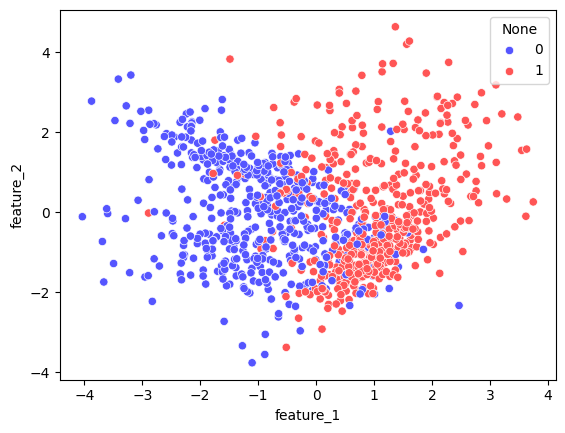

In [26]:
from sklearn import datasets
X, y = datasets.make_classification(
    n_samples=1000, #количество объектов
    n_features=2, #количество признаков
    n_informative=2, #количество информативных признаков
    n_redundant=0, #количество неинформативных признаков
    n_classes=2, #количество классов
    n_clusters_per_class=2, #количество кластеров внутри класса
    random_state=1 #генератор случайных чисел
)
X = pd.DataFrame(X, columns=['feature_1', 'feature_2'])
y = pd.Series(y)
sns.scatterplot(x=X['feature_1'], y=X['feature_2'], hue=y, palette='seismic');

In [27]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.3, random_state=42)
model = tree.DecisionTreeClassifier(
    max_depth=10
)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
print('Train accuracy: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('Valid accuracy: {:.2f}'.format(metrics.accuracy_score(y_valid, y_valid_pred)))

Train accuracy: 0.98
Valid accuracy: 0.83


график

In [30]:
def plot_probabilities_2d(X, y, model):
    #Генерируем координатную сетку из всех возможных значений для признаков
    #Результат работы функции — два массива xx1 и xx2, которые образуют координатную сетку
    xx1, xx2 = np.meshgrid(
        np.arange(X.iloc[:, 0].min()-1, X.iloc[:, 0].max()+1, 0.1),
        np.arange(X.iloc[:, 1].min()-1, X.iloc[:, 1].max()+1, 0.1)
    )
    #Вытягиваем каждый из массивов в вектор-столбец — reshape(-1, 1)
    #Объединяем два столбца в таблицу с помощью hstack
    X_net = np.hstack([xx1.reshape(-1, 1), xx2.reshape(-1, 1)])
    #Предсказываем вероятность для всех точек на координатной сетке
    #Нам нужна только вероятность класса 1
    probs = model.predict_proba(X_net)[:, 1]
    #Переводим столбец из вероятностей в размер координатной сетки
    probs = probs.reshape(xx1.shape)
    #Создаём фигуру и координатную плоскость
    fig, ax = plt.subplots(figsize = (10, 5))
    #Рисуем тепловую карту вероятностей
    contour = ax.contourf(xx1, xx2, probs, 100, cmap='bwr')
    #Рисуем разделяющую плоскость — линию, где вероятность равна 0.5
    bound = ax.contour(xx1, xx2, probs, [0.5], linewidths=2, colors='black');
    #Добавляем цветовую панель 
    colorbar = fig.colorbar(contour)
    #Накладываем поверх тепловой карты диаграмму рассеяния
    sns.scatterplot(x=X.iloc[:, 0], y=X.iloc[:, 1], hue=y, palette='seismic', ax=ax)
    #Даём графику название
    ax.set_title('Scatter Plot with Decision Boundary');
    #Смещаем легенду в верхний левый угол вне графика
    ax.legend(bbox_to_anchor=(-0.05, 1))

import numpy as np
import plotly.express as px
import plotly.graph_objects as go

def plot_probabilities_2d_px(X, y, model):
    # Генерируем координатную сетку из всех возможных значений для признаков
    xx1, xx2 = np.meshgrid(
        np.arange(X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1, 0.1),
        np.arange(X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1, 0.1)
    )
    
    # Вытягиваем каждый из массивов в вектор-столбец — reshape(-1, 1)
    # Объединяем два столбца в таблицу с помощью hstack
    X_net = np.hstack([xx1.reshape(-1, 1), xx2.reshape(-1, 1)])
    
    # Предсказываем вероятность для всех точек на координатной сетке
    # Нам нужна только вероятность класса 1
    probs = model.predict_proba(X_net)[:, 1]
    
    # Переводим столбец из вероятностей в размер координатной сетки
    probs = probs.reshape(xx1.shape)
    
    # Создаем тепловую карту вероятностей
    fig = px.density_heatmap(
        x=xx1.flatten(), 
        y=xx2.flatten(), 
        z=probs.flatten(),
        nbinsx=len(np.unique(xx1)), nbinsy=len(np.unique(xx2)),
        color_continuous_scale="RdBu_r",
        title='Heatmap',
        width=800,
        height=500)
    
    # Рисуем разделяющую плоскость — линию, где вероятность равна 0.5
    boundary_x, boundary_y = np.where(probs == 0.5)
    fig.add_trace(go.Scatter(x=boundary_x, y=boundary_y, mode='markers+lines', marker=dict(size=20), line=dict(color='white', width=4)))
    
    # Накладываем поверх тепловой карты диаграмму рассеяния
    scatter_data = px.scatter(x=X.iloc[:, 0], y=X.iloc[:, 1], color=y, color_discrete_sequence=["blue", "red"])
    fig.add_traces(scatter_data.data)
    
    return fig

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names



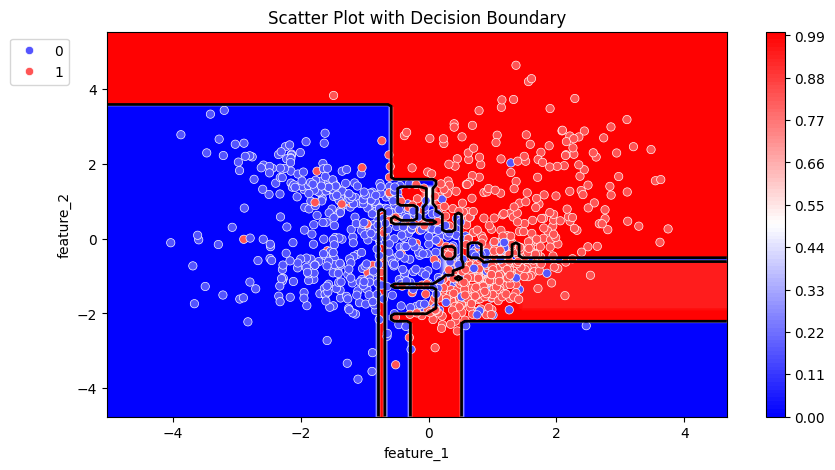

In [32]:
plot_probabilities_2d(X, y, model)
plot_probabilities_2d_px(X, y, model)

___

In [33]:
print('Current depth:', model_bad.get_depth())
## Current depth: 27

Current depth: 27


In [36]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #ограничиваем глубину дерева
    random_state=42, #генератор случайных чисел
    class_weight='balanced' #веса классов
)
 
#Создаём объект кросс-валидатора k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
 
#Считаем метрики на кросс-валидации k-fold со стратификацией
cv_metrics = model_selection.cross_validate(
    estimator=model, #модель
    X=X, #матрица наблюдений X
    y=y, #вектор ответов y
    cv=skf, #кросс-валидатор
    scoring='f1', #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)
 
print('Train k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['test_score'])))


## Train k-fold mean f1: 0.75
## Valid k-fold mean f1: 0.66

Train k-fold mean f1: 0.75
Valid k-fold mean f1: 0.66


In [37]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #ограничиваем глубину дерева
    min_samples_leaf=5, #увеличиваем количество объектов в листе
    random_state=42, #генератор случайных чисел
    class_weight='balanced' #веса классов
)
 
#Создаём объект кросс-валидатора k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
 
#Считаем метрики на кросс-валидации k-fold со стратификацией
cv_metrics = model_selection.cross_validate(
    estimator=model, #модель
    X=X, #матрица наблюдений X
    y=y, #вектор ответов y
    cv=skf, #кросс-валидатор
    scoring='f1', #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)
 
print('Train k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['test_score'])))
## Train k-fold mean f1: 0.74
## Valid k-fold mean f1: 0.66

Train k-fold mean f1: 0.74
Valid k-fold mean f1: 0.66


Train accuracy: 0.88
Valid accuracy: 0.85


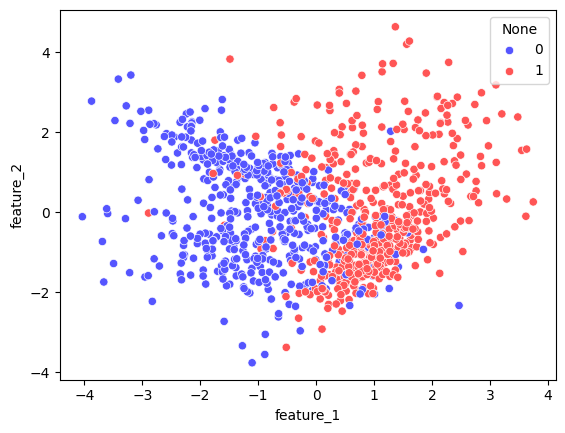

In [38]:
X, y = datasets.make_classification(
    n_samples=1000, #количество объектов
    n_features=2, #количество признаков
    n_informative=2, #количество информативных признаков
    n_redundant=0, #количество неинформативных признаков
    n_classes=2, #количество классов
    n_clusters_per_class=2, #количество кластеров внутри класса
    random_state=1 #генератор случайных чисел
)
X = pd.DataFrame(X, columns=['feature_1', 'feature_2'])
y = pd.Series(y)
sns.scatterplot(x=X['feature_1'], y=X['feature_2'], hue=y, palette='seismic')
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.3, random_state=42)
clf = tree.DecisionTreeClassifier(max_depth=3)
clf = clf.fit(X_train, y_train)
y_train_pred = clf.predict(X_train)
y_valid_pred = clf.predict(X_valid)
print('Train accuracy: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('Valid accuracy: {:.2f}'.format(metrics.accuracy_score(y_valid, y_valid_pred)))